# import des librarys

In [1]:
import tensorflow as tf 
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

2024-07-01 15:22:11.389580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/abdul/Desktop/CNN_prediction/training/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Fixation des constantes d'imahe
images_size=256 # Taille de nos images
batchs_size=32 # Taille de notre batch d'images pour determiner la taille des echantillongs
channels=3 # Nombre de canaux de couleur

In [3]:
# import des donnes de PlantVIllage
data_set=tf.keras.preprocessing.image_dataset_from_directory(
     "PlantVillage",
     shuffle=True,
     image_size=(images_size,images_size),
     batch_size=batchs_size
)

Found 2152 files belonging to 3 classes.


In [4]:
# Visualisation des noms des classes
class_names=data_set.class_names
print(class_names)

['Potato___Alternariose', 'Potato___Mildiou', 'Potato___saine']


In [6]:
# Taille d'un batch
print(len(data_set))
# Taille du dataset 
print(len(data_set)*batchs_size)

68
2176


# Visualisation des images

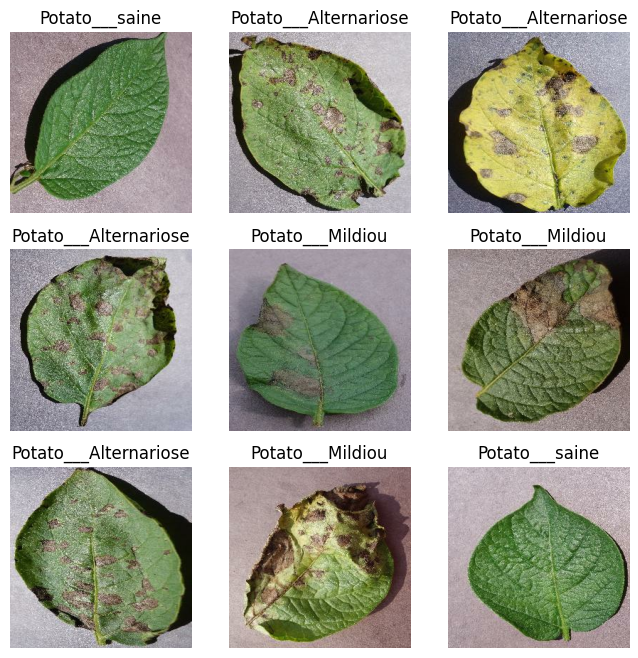

In [14]:
# Taille affichage des images
plt.figure(figsize=(8, 8))
# Affichage des images
for image_batch, labels_batch in data_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Preparation des donnes pour la modélisaiton

In [15]:
# Creation d'une fontion de séparation
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
# Applicaiton de la fonction
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data_set)

In [18]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


## Mise en cache des données en vue d'acelérer les calculs car pas de GPU

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creation du modèle

In [20]:
# Formatage des images
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(images_size, images_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# Enrichissement des données à l'aide de la data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
# Application de la data augmentation
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Création du modèle CNN

In [37]:
input_shape = (batchs_size, images_size, images_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
# Sommaire du model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [38]:
# Compilation du model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
# Calcul de l'entrainement et suivi
history = model.fit(
    train_ds,
    batch_size=batchs_size,
    validation_data=val_ds,
    verbose=1,
    epochs=10, # Nombre de fois que le model va etre entrainé sur entiereté du dataset
)

Epoch 1/10
54/54 [==============================] - 72s 1s/step - loss: 0.7831 - accuracy: 0.6603 - val_loss: 1.2884 - val_accuracy: 0.6667
Epoch 2/10
54/54 [==============================] - 72s 1s/step - loss: 0.4297 - accuracy: 0.8438 - val_loss: 0.7381 - val_accuracy: 0.7604
Epoch 3/10
54/54 [==============================] - 73s 1s/step - loss: 0.3651 - accuracy: 0.8524 - val_loss: 0.3707 - val_accuracy: 0.8177
Epoch 4/10
54/54 [==============================] - 73s 1s/step - loss: 0.3388 - accuracy: 0.8692 - val_loss: 0.3024 - val_accuracy: 0.8802
Epoch 5/10
54/54 [==============================] - 75s 1s/step - loss: 0.2348 - accuracy: 0.9005 - val_loss: 0.1839 - val_accuracy: 0.9271
Epoch 6/10
54/54 [==============================] - 76s 1s/step - loss: 0.1697 - accuracy: 0.9427 - val_loss: 0.1780 - val_accuracy: 0.9219
Epoch 7/10
54/54 [==============================] - 74s 1s/step - loss: 0.1585 - accuracy: 0.9398 - val_loss: 0.2645 - val_accuracy: 0.9010
Epoch 8/10
54/54 [==

On voit qu'avec un epoch à 10 on attend la meilleur validation avec 97%

# Visualisaiton des prédicitons

premier image a predire
Vrai classe: Potato___Alternariose
1/1 [==============================] - 1s 593ms/step
Classe predite: Potato___Alternariose


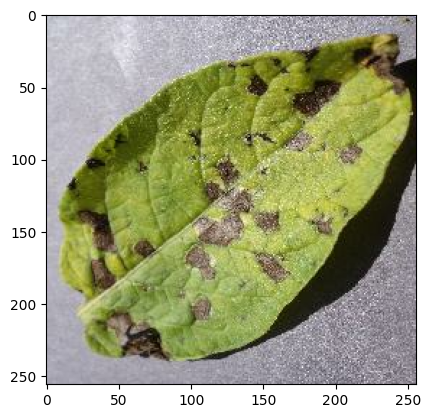

In [42]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("premier image a predire")
    plt.imshow(first_image)
    print("Vrai classe:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Classe predite:",class_names[np.argmax(batch_prediction[0])])

In [45]:
# Creation d'une fonction pour afficher les resultats predits
def prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


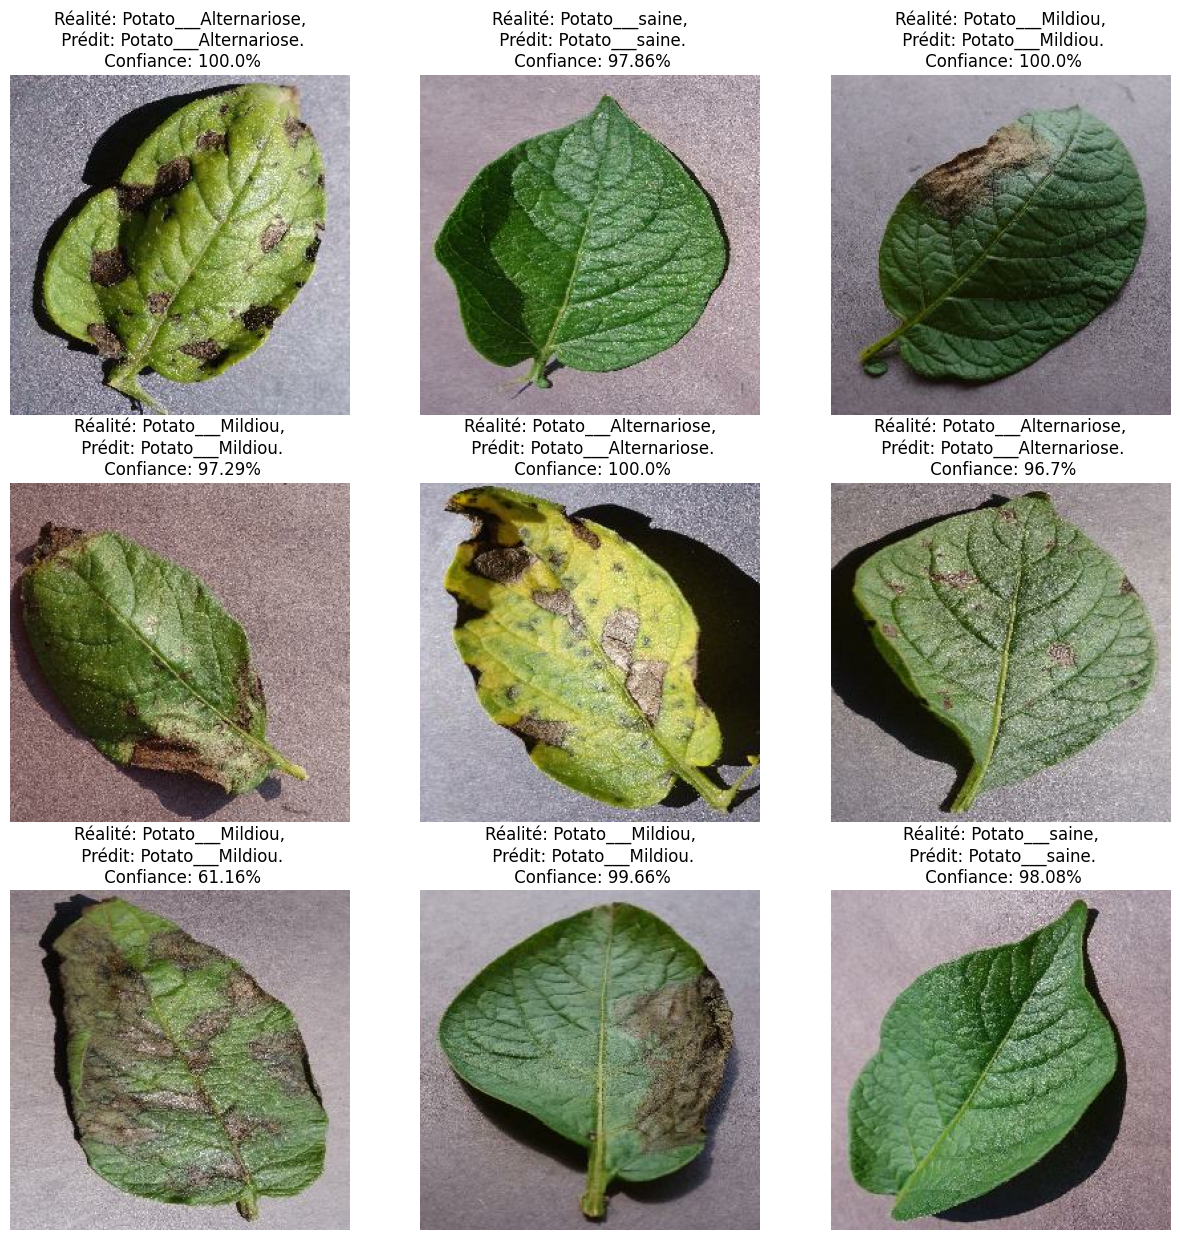

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = prediction(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Réalité: {actual_class},\n Prédit: {predicted_class}.\n Confiance: {confidence}%")
        
        plt.axis("off")

# Sauvegarde du model

In [55]:
model_version = "1"
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets
